# Smartphone Battery Life Predictor
An ML model for prediction how much time a phone battery has left before it is depleted.

By: Mats van Liempd

Version: 2.1.0

In [1]:
import sklearn as skl
import numpy as np
import matplotlib as mpl
import seaborn as sb
import pandas as pd

#### Importing The Dataset

In [2]:
data = pd.read_csv("datasets/Data Collection Smartphone Battery Life(Sheet1)_with_capacity_with_estimated_life.csv")
data.head()
data.sort_values(by="sessionlength", ascending=False)

,Id,userage,usergender,userphone,phoneos,batteryhealth,startbatterypercentage,endbatterypercentage,sessionlength,timedonphone,appcount,screenbrightness,usednetwork,usedbluetooth,usedGPS,usedbatterysaving,batterycapacity_mAh,estimated_remaining_life_s
30,31,23,Man,iPhone 15,iOs,100,100,39,21663,No,6,45,Yes,No,No,No,3349,35513.0
32,33,22,Prefer not to say,Samsung Galaxy S23,Android,100,100,43,21663,No,6,45,Yes,No,No,No,3900,38005.0
31,32,22,Prefer not to say,Google Pixel 8,Android,100,100,44,21663,No,6,45,Yes,No,No,No,4575,38684.0
12,13,24,Man,iPhone 16,iOs,100,100,64,18034,No,4,100,Yes,No,No,No,3561,50094.0
13,14,25,Man,Samsung Galaxy S25 Ultra,Android,100,100,69,18034,No,4,100,Yes,No,No,No,5000,58174.0
11,12,26,Man,iPhone 16 Pro Max,iOs,100,100,71,18034,No,4,100,Yes,No,No,No,4685,62186.0
7,8,26,Man,iPhone 17 Pro Max,iOs,100,100,73,18034,No,4,100,Yes,No,No,No,5088,66793.0
9,10,25,Man,iPhone Air,iOs,100,100,51,18034,No,4,100,Yes,No,No,No,3149,36804.0
8,9,26,Man,iPhone 17 Pro,iOs,100,100,66,18034,No,4,100,Yes,No,No,No,4252,53041.0
10,11,25,Man,iPhone 17,iOs,100,100,64,18034,No,4,100,Yes,No,No,No,3692,50094.0


#### Data Cleaning
Making the data usable with actual models

In [3]:
df = pd.DataFrame(data)
df = df.drop(columns=["Id"])

 
# change phoneos to 0 (iOs) and 1 (Android) 
df["phoneos"] = df["phoneos"].str.strip().str.lower().map({
    "ios": 0,
    "android": 1
})

# change all yes/no collumns in the data set to 1/0 booleans
yes_no_cols = [
    col for col in df.columns
    if df[col].astype(str).str.lower().isin(["yes", "no"]).any() and col != "phoneos"
]

for col in yes_no_cols:
    df[col] = df[col].astype(str).str.strip().str.lower().map({
        "yes": 1,
        "no": 0
    })

# converting gender options to numerical values
df["usergender"] = df["usergender"].str.strip().str.lower().map({
    "man": 0,
    "woman": 1,
    "non-binary": 2,
    "prefer not to say": 3
})


df.sample(5)

,userage,usergender,userphone,phoneos,batteryhealth,startbatterypercentage,endbatterypercentage,sessionlength,timedonphone,appcount,screenbrightness,usednetwork,usedbluetooth,usedGPS,usedbatterysaving,batterycapacity_mAh,estimated_remaining_life_s
7,26,0,iPhone 17 Pro Max,0,100,100,73,18034,0,4,100,1,0,0,0,5088,66793.0
18,19,0,Iphone 13,0,80,46,42,942,0,4,50,1,0,1,0,3227,10833.0
0,20,0,iPhone 12,0,97,70,62,1212,0,5,75,1,1,0,0,2815,10605.0
27,20,0,iPhone 14 Pro Max,0,100,100,63,15132,0,4,45,1,0,0,0,4323,40897.0
9,25,0,iPhone Air,0,100,100,51,18034,0,4,100,1,0,0,0,3149,36804.0


#### Feature Selection

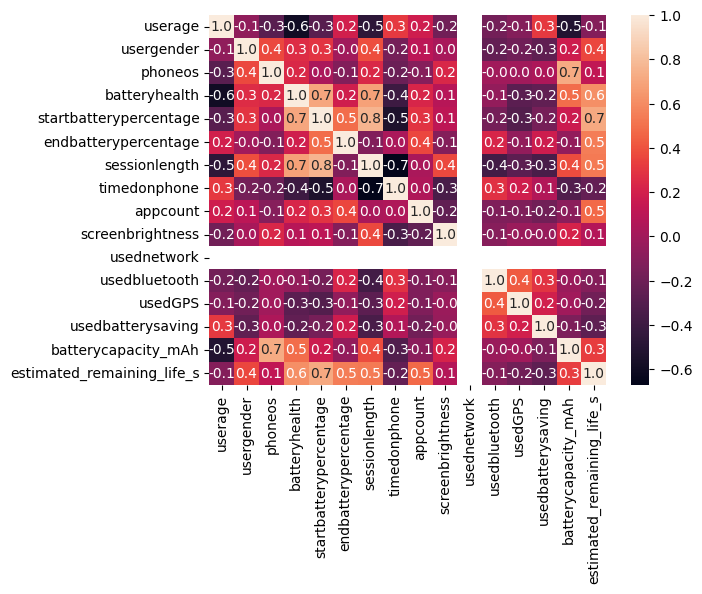

In [4]:
# correlations = df.corr()
correlations = df.select_dtypes(include='number').corr()
plot = sb.heatmap(correlations, cbar=True, annot=True, fmt=".1f")

a lot of possibly usefull features spotted, im happy

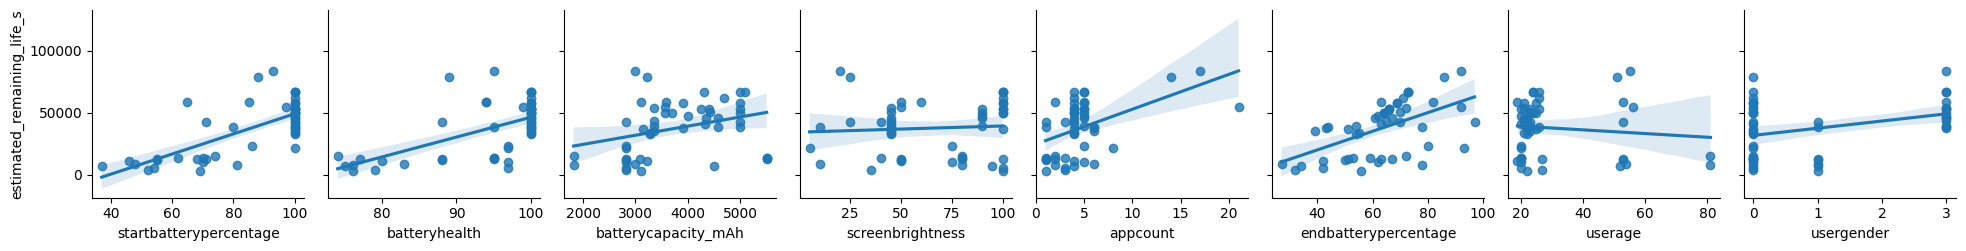

In [5]:
candidates = ["startbatterypercentage", "batteryhealth", "batterycapacity_mAh", "screenbrightness", "appcount", "endbatterypercentage", "userage", "usergender"]
plot = sb.pairplot(df, x_vars=candidates, y_vars="estimated_remaining_life_s", kind="reg")

i can forsee a possible problem as not all of the data looks as linear as i thought i would look

#### Splitting The Data & Normalization

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#features = [ "startbatterypercentage","batteryhealth", "batterycapacity_mAh", "screenbrightness", "timedonphone", "appcount", "usednetwork", "usedbluetooth", "usedGPS", "usedbatterysaving", "phoneos"] # -> tested all features' performance

features = ["startbatterypercentage", "batteryhealth", "batterycapacity_mAh", "screenbrightness", "appcount", "endbatterypercentage"] # -> tested more limited intentionally chosen features' performance

#features = ["startbatterypercentage", "batteryhealth", "batterycapacity_mAh"] # -> tested the minimal features' performance (only the highest correlating features)

target = "estimated_remaining_life_s"
X = df[features]
y = df[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = df['estimated_remaining_life_s'] / 3600

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

There are in total 51 observations, of which 40 are now in the train set, and 11 in the test set.


#### Training The Model (Linear Regression)

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
model = LinearRegression()
result = model.fit(X_train, y_train)
score = model.score(X_test, y_test)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred) * 3600 # non scaled mean absolute error

print("R²:", score)
print(f"MAE: {int(mae // 3600)}h {int((mae % 3600) // 60)}m {int(mae % 60)}s ({mae})")

R²: 0.5485109979764171
MAE: 3h 20m 34s (12034.586590733696)


linear is NOT working ;-; -> conclusion: data is not linear

### Testing other possible models

#### Random Forest Regressor

In [8]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred) * 3600 # non scaled mean absolute error
print("R²:", score)
print(f"MAE: {int(mae // 3600)}h {int((mae % 3600) // 60)}m {int(mae % 60)}s ({mae})")

R²: 0.496480194144056
MAE: 3h 1m 40s (10900.749999999998)


this is definitely an improvement over the linear model, but 2 and a half hours off is still a lot and not at all what I want.

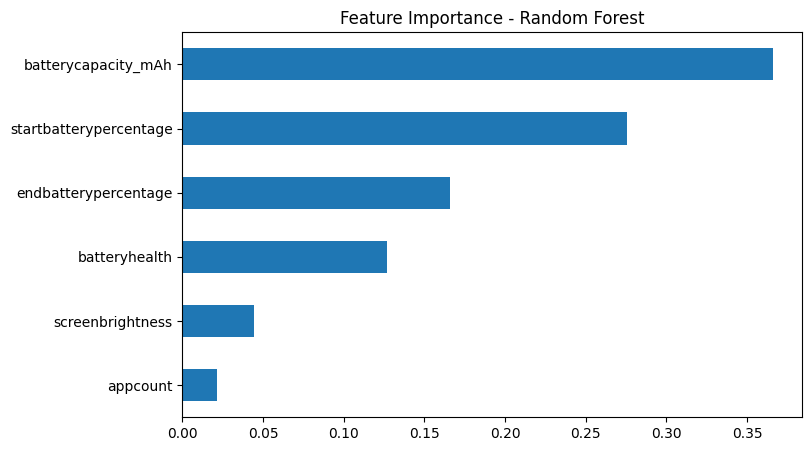

In [9]:
import matplotlib.pyplot as plt
importance = pd.Series(model.feature_importances_, index=X.columns).sort_values()
importance.plot(kind="barh", figsize=(8,5), title="Feature Importance - Random Forest")
plt.show()

the feature importance seems quite logical and good :D

#### Gradient Boosting Regressor

In [10]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(random_state=42)
# model = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=4, random_state=42) # -> weaker results
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred) * 3600 # non scaled mean absolute error
print("R²:", score)
print(f"MAE: {int(mae // 3600)}h {int((mae % 3600) // 60)}m {int(mae % 60)}s ({mae})")

R²: 0.5067155098850069
MAE: 2h 34m 20s (9260.535466898025)


Very good results compared to the other 2 models so ill be going with this one :)

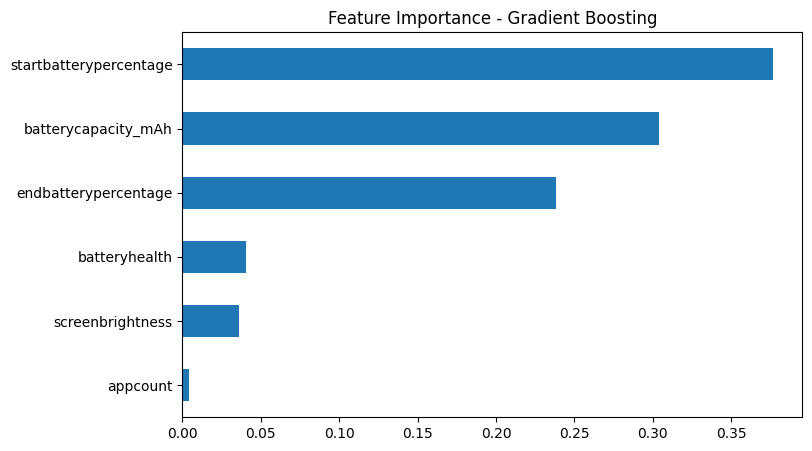

In [11]:
import matplotlib.pyplot as plt
importance = pd.Series(model.feature_importances_, index=X.columns).sort_values()
importance.plot(kind="barh", figsize=(8,5), title="Feature Importance - Gradient Boosting")
plt.show()

the feature importance seems incredibly skewed.

### Conclusion Iteration 0
From now on I will be using the Gradient Boosting Regressor as it is already yielding the highest results. I also will need way more data for the Mean Absolute Error to go down and actually yield results that can be used, since results that are 1 hour+ off of the actual battery life is just not acceptable. The good thing is that the R² is really close to 1, which means the model is performing well and this is why I assume I need more data for it to properly function.

### Extra Trees Regressor
After Checking 9 Regressor models I concluded Extra Trees as the best

#### Setting up model

In [12]:
from sklearn.ensemble import ExtraTreesRegressor

model = ExtraTreesRegressor(
    n_estimators=200,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

#### Performing Cross validation
I forgot this last iteration

In [13]:
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_mae = -cross_val_score(model, X, y, cv=kf, scoring="neg_mean_absolute_error", n_jobs=-1)
cv_r2 = cross_val_score(model, X, y, cv=kf, scoring="r2", n_jobs=-1)

print(f"Cross-Validation MAE: {cv_mae.mean():.2f} ± {cv_mae.std():.2f} hours")
print(f"Cross-Validation R²:  {cv_r2.mean():.3f} ± {cv_r2.std():.3f}")

Cross-Validation MAE: 1.94 ± 0.45 hours
Cross-Validation R²:  0.633 ± 0.120


#### Testing

In [14]:
from sklearn.metrics import r2_score

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae_test = mean_absolute_error(y_test, y_pred) * 3600  # seconds
r2_test = r2_score(y_test, y_pred)

print("\nTest Set Results:")
print(f"R²: {r2_test:.3f}")
print(f"MAE: {int(mae_test // 3600)}h {int((mae_test % 3600) // 60)}m {int(mae_test % 60)}s ({mae_test:.2f} seconds)")


Test Set Results:
R²: 0.777
MAE: 2h 6m 21s (7581.47 seconds)


#### Feature importance

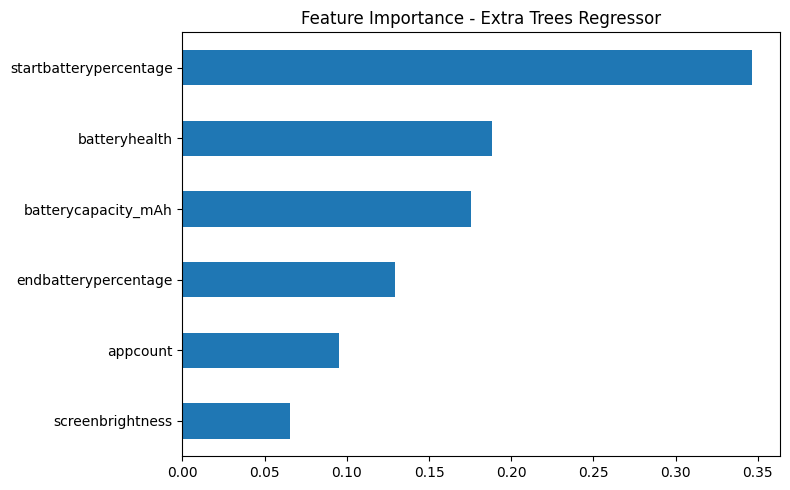

In [15]:
importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=True)
plt.figure(figsize=(8, 5))
importance.plot(kind="barh", title="Feature Importance - Extra Trees Regressor")
plt.tight_layout()
plt.show()

## Merging with Modified Sherlock Dataset

#### Importing and converting the Sherlock Dataframe

In [16]:
import random

sherlock_df = pd.read_csv("datasets/sherlock/mod/T4_Cleaned.csv")
sherlock_df["Battery_timestamp"] = pd.to_datetime(sherlock_df["Battery_timestamp"])
sherlock_df = sherlock_df.sort_values("Battery_timestamp").reset_index(drop=True)

total_sherlock_rows = len(sherlock_df)
sessions = []
i = 0

while i < total_sherlock_rows:
    session_duration_s = random.randint(600, 1800)
    rows_in_session = int(session_duration_s / 5)  # +-5 s per record
    end_idx = min(i + rows_in_session, total_sherlock_rows)
    group = sherlock_df.iloc[i:end_idx]

    sherlock_random_userage = random.randint(18, 29)

    start_battery = group["Battery_level"].iloc[0]
    end_battery = group["Battery_level"].iloc[-1]
    session_length = (
        group["Battery_timestamp"].iloc[-1] - group["Battery_timestamp"].iloc[0]
    ).total_seconds()

    group["drain_rate_percent_per_s"] = (
        group["Battery_level"].shift(1) - group["Battery_level"]
    ) / (group["Battery_timestamp"] - group["Battery_timestamp"].shift(1)).dt.total_seconds()

    group["drain_rate_percent_per_s"] *= (1 + group["Total_CPU"] / 100.0)
    mean_drain = group["drain_rate_percent_per_s"].mean()

    mean_cpu = group["Total_CPU"].mean()
    mean_temp = group["Battery_temperature"].mean() if "Battery_temperature" in group else 25
    battery_health = (
        group["Battery_health"].mode()[0]
        if not group["Battery_health"].isna().all()
        else np.nan
    )

    mean_temp = group["Battery_temperature"].mean() if "Battery_temperature" in group else 25
    cpu_factor = min(mean_cpu / 100, 1)  # normalized CPU 0–1

    base_brightness = 20 + (cpu_factor ** 1.2) * 60 + (mean_temp - 25) * 0.5 + random.uniform(-5, 5)

    start_hour = group["Battery_timestamp"].iloc[0].hour
    if 22 <= start_hour or start_hour < 6:
        brightness_factor = 0.5  # night
    elif 6 <= start_hour < 9 or 18 <= start_hour < 22:
        brightness_factor = 0.8  # morning/evening
    else:
        brightness_factor = 1.0  # daytime

    screen_brightness = int(np.clip(base_brightness * brightness_factor, 10, 100))

    used_network = "Yes" if group["connectedWifi_SSID"].notna().any() or mean_cpu > 10 else "No"
    appcount = int(np.clip(mean_cpu / 10, 1, 10))
    estimated_remaining_life_s = (
        end_battery / mean_drain if mean_drain and mean_drain > 0 else np.nan
    )

    sessions.append({
        "userage": sherlock_random_userage,
        "userphone": "Samsung Galaxy S6",
        "usergender": "Prefer not to say",
        "phoneos": "Android",
        "batteryhealth": battery_health,
        "startbatterypercentage": start_battery,
        "endbatterypercentage": end_battery,
        "sessionlength": round(session_length, 2),
        "timedonphone": "Yes",
        "appcount": appcount,
        "screenbrightness": screen_brightness,
        "usednetwork": used_network,
        "usedbluetooth": "No",
        "usedGPS": "No",
        "usedbatterysaving": "No",
        "batterycapacity_mAh": 2550,
        "estimated_remaining_life_s": (
            round(estimated_remaining_life_s)
            if not np.isnan(estimated_remaining_life_s)
            else None
        )
    })

    i = end_idx

sherlock_df = pd.DataFrame(sessions).dropna()
sherlock_df.head(10)


C:\Users\Mats van Liempd\AppData\Local\Temp\ipykernel_54472\1911855206.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group["drain_rate_percent_per_s"] = (
C:\Users\Mats van Liempd\AppData\Local\Temp\ipykernel_54472\1911855206.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group["drain_rate_percent_per_s"] *= (1 + group["Total_CPU"] / 100.0)
C:\Users\Mats van Liempd\AppData\Local\Temp\ipykernel_54472\1911855206.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

,userage,userphone,usergender,phoneos,batteryhealth,startbatterypercentage,endbatterypercentage,sessionlength,timedonphone,appcount,screenbrightness,usednetwork,usedbluetooth,usedGPS,usedbatterysaving,batterycapacity_mAh,estimated_remaining_life_s
0,23,Samsung Galaxy S6,Prefer not to say,Android,2.0,61.0,59.0,1123.25,Yes,2,100,Yes,No,No,No,2550,24384.0
1,28,Samsung Galaxy S6,Prefer not to say,Android,2.0,59.0,58.0,1192.28,Yes,2,100,Yes,No,No,No,2550,49820.0
2,28,Samsung Galaxy S6,Prefer not to say,Android,2.0,58.0,55.0,1700.76,Yes,2,100,Yes,No,No,No,2550,25127.0
3,27,Samsung Galaxy S6,Prefer not to say,Android,2.0,55.0,52.0,1939.47,Yes,2,100,Yes,No,No,No,2550,22656.0
4,26,Samsung Galaxy S6,Prefer not to say,Android,2.0,52.0,49.0,1872.26,Yes,2,100,Yes,No,No,No,2550,20571.0
5,25,Samsung Galaxy S6,Prefer not to say,Android,2.0,49.0,48.0,1218.09,Yes,1,100,Yes,No,No,No,2550,44541.0
6,21,Samsung Galaxy S6,Prefer not to say,Android,2.0,48.0,47.0,748.81,Yes,2,100,Yes,No,No,No,2550,32183.0
7,27,Samsung Galaxy S6,Prefer not to say,Android,2.0,47.0,45.0,1122.72,Yes,2,100,Yes,No,No,No,2550,23048.0
8,25,Samsung Galaxy S6,Prefer not to say,Android,2.0,45.0,44.0,800.70,Yes,2,100,Yes,No,No,No,2550,25825.0
9,21,Samsung Galaxy S6,Prefer not to say,Android,2.0,44.0,42.0,1316.88,Yes,1,100,Yes,No,No,No,2550,25946.0


#### Cleaning Sherlock Dataframe

In [17]:
# change phoneos to 0 (iOs) and 1 (Android) 
sherlock_df["phoneos"] = sherlock_df["phoneos"].str.strip().str.lower().map({
    "ios": 0,
    "android": 1
})

# change all yes/no collumns in the data set to 1/0 booleans
sherlock_yes_no_cols = [
    col for col in df.columns
    if sherlock_df[col].astype(str).str.lower().isin(["yes", "no"]).any() and col != "phoneos"
]

for col in sherlock_yes_no_cols:
    sherlock_df[col] = sherlock_df[col].astype(str).str.strip().str.lower().map({
        "yes": 1,
        "no": 0
    })

# converting gender options to numerical values
sherlock_df["usergender"] = sherlock_df["usergender"].str.strip().str.lower().map({
    "man": 0,
    "woman": 1,
    "non-binary": 2,
    "prefer not to say": 3
})



#### Merging the dataframes

In [18]:
#merged_df = df.merge(sherlock_df, how='inner')

merged_df = pd.concat([df, sherlock_df], ignore_index=True)
merged_df.head(75)

,userage,usergender,userphone,phoneos,batteryhealth,startbatterypercentage,endbatterypercentage,sessionlength,timedonphone,appcount,screenbrightness,usednetwork,usedbluetooth,usedGPS,usedbatterysaving,batterycapacity_mAh,estimated_remaining_life_s
0,20,0,iPhone 12,0,97.0,70.0,62.0,1212.00,0,5,75,1,1,0,0,2815,10605.0
1,20,0,iPhone 12,0,97.0,54.0,42.0,1159.00,1,3,100,1,0,0,0,2815,5216.0
2,20,0,ROG Phone 8 Pro Edition,1,95.0,62.0,53.0,1923.00,1,3,80,1,0,0,0,5500,13247.0
3,22,1,iPhone 11,0,76.0,69.0,56.0,600.00,0,1,100,1,0,0,0,3110,3185.0
4,27,0,Iphone 12,0,79.0,52.0,32.0,1500.00,1,3,35,1,0,0,0,2815,3900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,23,3,Samsung Galaxy S6,1,2.0,26.0,24.0,1593.60,1,1,100,1,0,0,0,2550,16917.0
71,25,3,Samsung Galaxy S6,1,2.0,24.0,23.0,941.07,1,1,100,1,0,0,0,2550,21550.0
72,28,3,Samsung Galaxy S6,1,2.0,23.0,21.0,1577.57,1,1,100,1,0,0,0,2550,16180.0
73,18,3,Samsung Galaxy S6,1,2.0,21.0,19.0,1675.63,1,1,97,1,0,0,0,2550,11203.0


#### Merged Dataframes Heatmap

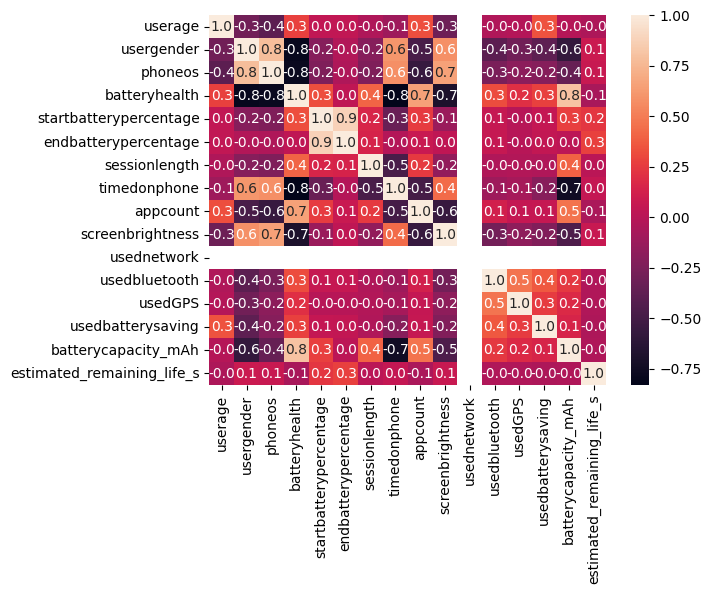

In [19]:
correlations = merged_df.select_dtypes(include='number').corr()
plot = sb.heatmap(correlations, cbar=True, annot=True, fmt=".1f")

#### Setting up model, features, target, training and testing

In [20]:
sherlock_model = ExtraTreesRegressor(
    n_estimators=200,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

features = ["startbatterypercentage", "batteryhealth", "batterycapacity_mAh", "screenbrightness", "appcount", "endbatterypercentage"] # -> tested more limited intentionally chosen features' performance

target = "estimated_remaining_life_s"
X = merged_df[features]
y = merged_df[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = merged_df['estimated_remaining_life_s'] / 3600

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

sherlock_model.fit(X_train, y_train)
y_pred = sherlock_model.predict(X_test)

mae_test = mean_absolute_error(y_test, y_pred) * 3600  # seconds
r2_test = r2_score(y_test, y_pred)

print("\nTest Set Results:")
print(f"R²: {r2_test:.3f}")
print(f"MAE: {int(mae_test // 3600)}h {int((mae_test % 3600) // 60)}m {int(mae_test % 60)}s ({mae_test:.2f} seconds)")

There are in total 430 observations, of which 344 are now in the train set, and 86 in the test set.

Test Set Results:
R²: -0.432
MAE: 10h 16m 33s (36993.16 seconds)


#### Kfold Validation

In [21]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_mae = -cross_val_score(sherlock_model, X, y, cv=kf, scoring="neg_mean_absolute_error", n_jobs=-1)
cv_r2 = cross_val_score(sherlock_model, X, y, cv=kf, scoring="r2", n_jobs=-1)

print(f"Cross-Validation MAE: {cv_mae.mean():.2f} ± {cv_mae.std():.2f} hours")
print(f"Cross-Validation R²:  {cv_r2.mean():.3f} ± {cv_r2.std():.3f}")

Cross-Validation MAE: 8.00 ± 2.10 hours
Cross-Validation R²:  -0.452 ± 0.509


#### Extra Trees Regressor: Feature Importance

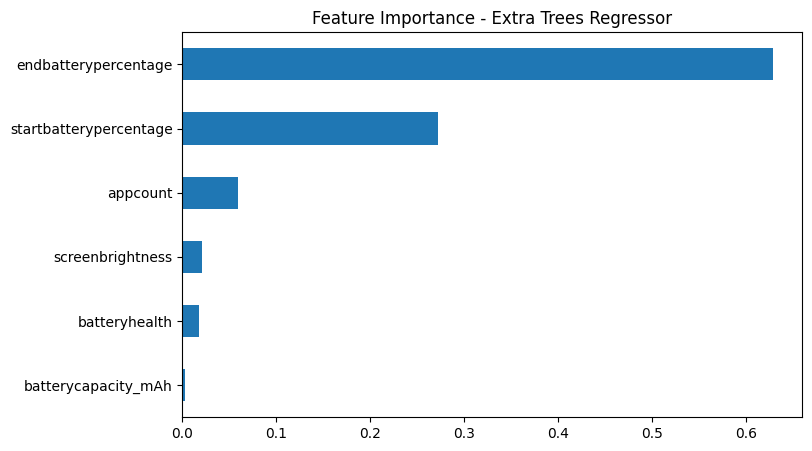

In [22]:
importance = pd.Series(sherlock_model.feature_importances_, index=X.columns).sort_values()
importance.plot(kind="barh", figsize=(8,5), title="Feature Importance - Extra Trees Regressor")
plt.show()

### Conclusion
So the dataset merging is not really successful as the new data added overshadows the original survey data. This also shows that when merged the merged data inherits the same issues the Sherlock data had before, this being that since the data is solely based on one device and thus the different device data and feature correlations fall flat. It could also be that the parts of the data I had to make a(n) (educated) guess on, where not accurate but I honestly doubt this being the case, since I see the exact pattern in the feature correlation heatmap of the Sherlock dataset and the merged dataset. Next time I will try to either find other datasets of about the same size, or try to convert the data from the into less entries so that the original survey data remains relevant.

## Exporting the model for web app

In [ ]:
df.head()

In [23]:
import pickle
pickle.dump(model, open("battery_model.pkl", "wb"))